In [1]:
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.5/939.5 kB 13.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.1/101.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 67.4 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.7-cp310-cp310-linux_x86_64.whl size=830296 sha256=b18acca77eba44f05fc5a4be1e0ce793226e2e5c736ab9e3aed57ec592d564c6
  Stored in directory: /root/.cache/pip/wheels/8d/0e/f8/48eb93a200fca4c502d7590613616fa4d2c9533f7308f9e28a
Successfully built peewee


In [2]:
import datetime as dt
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (
    Input,
    Dense,
    MultiHeadAttention,
    Dropout,
    GlobalAveragePooling1D,
)
from tensorflow.keras.models import Model

In [3]:
data = yf.download("AAPL", start="2018-01-01", end=dt.date.today())
window_length = 7


[*********************100%***********************]  1 of 1 completed


In [4]:
data["MACD"] = (
    data["Close"].ewm(span=12, adjust=False).mean()
    - data["Close"].ewm(span=26, adjust=False).mean()
)
data["Signal_Line"] = data["MACD"].ewm(span=9, adjust=False).mean()
data["MACD_diff"] = data["MACD"] - data["Signal_Line"]

delta = data["Close"].diff(1)
delta = delta[1:]
up, down = delta.copy(), delta.copy()
up[up < 0] = 0
down[down > 0] = 0
data["RSI"] = 100 - (
    100
    / (
        1
        + (up.rolling(window_length).mean() / down.abs().rolling(window_length).mean())
    )
)

data["SMA_20"] = data["Close"].rolling(window=20).mean()
data["SMA_50"] = data["Close"].rolling(window=50).mean()
data["SMA_100"] = data["Close"].rolling(window=100).mean()

df = data[["MACD_diff", "RSI", "SMA_20", "SMA_50", "SMA_100", "Close"]].dropna()
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)


In [5]:
def create_dataset(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i : (i + look_back), :-1])
        y.append(data[i + look_back, -1])
    return np.array(X), np.array(y)


# Parameters for the model
look_back = window_length

# Create dataset
X, y = create_dataset(df_scaled, look_back)

# Split into train and test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [6]:
def transformer_model(input_shape):
    inputs = Input(shape=input_shape)
    x = MultiHeadAttention(num_heads=6, key_dim=3, dropout=0.1)(inputs, inputs)
    x = GlobalAveragePooling1D()(x)

    x = Dense(64, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(32, activation="relu")(x)
    x = Dropout(0.1)(x)

    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    return model


model = transformer_model((look_back, X_train.shape[2]))

model.compile(optimizer="adam", loss="mean_squared_error")


In [7]:
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=100,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
)


Epoch 1/100
41/41 [==============================] - 2s 9ms/step - loss: 0.0432 - val_loss: 0.0193
Epoch 2/100
41/41 [==============================] - 0s 5ms/step - loss: 0.0066 - val_loss: 0.0110
Epoch 3/100
41/41 [==============================] - 0s 5ms/step - loss: 0.0053 - val_loss: 0.0034
Epoch 4/100
41/41 [==============================] - 0s 5ms/step - loss: 0.0048 - val_loss: 0.0056
Epoch 5/100
41/41 [==============================] - 0s 5ms/step - loss: 0.0044 - val_loss: 0.0047
Epoch 6/100
41/41 [==============================] - 0s 5ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 7/100
41/41 [==============================] - 0s 5ms/step - loss: 0.0038 - val_loss: 0.0057
Epoch 8/100
41/41 [==============================] - 0s 5ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 9/100
41/41 [==============================] - 0s 5ms/step - loss: 0.0033 - val_loss: 0.0025
Epoch 10/100
41/41 [==============================] - 0s 5ms/step - loss: 0.0035 - val_loss: 0.0056
Epoch 11/

In [8]:
y_pred = model.predict(X_test)

y_pred_rescaled = scaler.inverse_transform(
    np.concatenate(
        (np.zeros((y_pred.shape[0], df_scaled.shape[1] - 1)), y_pred), axis=1
    )
)[:, -1]
y_test_rescaled = scaler.inverse_transform(
    np.concatenate(
        (np.zeros((y_test.shape[0], df_scaled.shape[1] - 1)), y_test.reshape(-1, 1)),
        axis=1,
    )
)[:, -1]

rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


11/11 [==============================] - 0s 2ms/step
Root Mean Squared Error (RMSE): 5.43


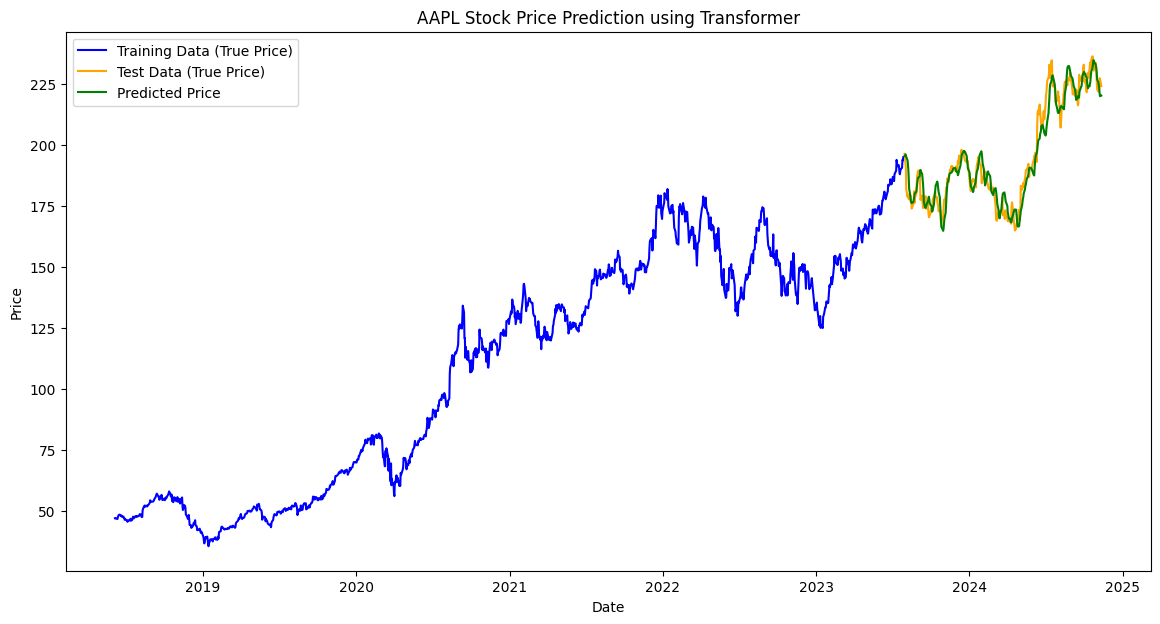

In [9]:
plt.figure(figsize=(14, 7))
dates = df.index[look_back:]
train_dates = dates[:train_size]
test_dates = dates[train_size:]

plt.plot(
    train_dates,
    scaler.inverse_transform(df_scaled[:train_size])[:, -1],
    label="Training Data (True Price)",
    color="blue",
)
plt.plot(test_dates, y_test_rescaled, label="Test Data (True Price)", color="orange")
plt.plot(test_dates, y_pred_rescaled, label="Predicted Price", color="green")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("AAPL Stock Price Prediction using Transformer")
plt.legend()
plt.show()
